In [21]:
# Imports
import sys
sys.path.append('./FDFD')
import os
import numpy as np
import matplotlib.pylab as plt
from scipy import misc
from time import time
from imageio import imread
from solveFDFD import solveFDFD
from NN import NN
from IPython.display import clear_output
%matplotlib inline

In [40]:
print(os.listdir('./test_images'))
device_name = 'inverse_design'

['DLA.png', 'inverse_design.png', 'PhC.png', 'ring_resonator.png', 'split_ring_resonator.png', 'splitter.png', 'squirrel.png']


In [59]:
# Define Parameters
xrange = [-1, 1]
yrange = [-1, 1]
layer_sizes = [2,40,40,40,40,40,1]
activations = ['tanh','tanh','tanh','tanh','tanh','sigmoid']

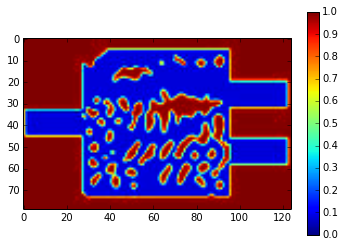

In [60]:
# load in data and noramlize to [0,1]
fname = './test_images/'+device_name+'.png'
eps_r = np.sum(imread(fname), axis=2)
minimum = np.min(eps_r)
eps_r = eps_r-minimum
maximum = np.max(eps_r)
eps_r = eps_r/1.0/maximum
Nx,Ny = eps_r.shape
plt.imshow(eps_r)
plt.colorbar()
plt.show()

In [61]:
# Set Up training examples Variables
num_free_parameters = sum([layer_sizes[i]*layer_sizes[i+1] for i in range(len(layer_sizes)-1)])
network_display_str = '->'.join(['[' + str(layer_sizes[i])+']' for i in range(len(layer_sizes))])
x_points = np.linspace(xrange[0],xrange[1],Nx)
y_points = np.linspace(yrange[0],yrange[1],Ny)
training_examples = np.zeros((2,Nx*Ny))
iteration = 0
for i in range(Nx):
    for j in range(Ny):
        training_examples[0,iteration] = x_points[i]
        training_examples[1,iteration] = y_points[j]
        iteration += 1        

In [ ]:
neuralNet = NN(layer_sizes,activations)
_ = neuralNet.derivative_check()
Js = []
learning_rate = 1e5
skip = 50
N_iterations = 100000
for i in range(N_iterations):
    A = neuralNet.forward_prop(training_examples)
    er_vec = np.reshape(eps_r,(1,Nx*Ny))
    dAdZ = A*(1.0-A)
    dJdA = 1.0/float(Nx)/float(Ny)*(er_vec-A)*dAdZ
    
    # Do original simulation and adjoint simulation
    J = 1/2.0*np.sum(np.power(er_vec-A,2))
    Js.append(J)
    neuralNet.back_prop(np.reshape(dJdA*dAdZ,(1,Nx*Ny)))
    neuralNet.update_weights(learning_rate=learning_rate)
    if i%skip == 0:
        clear_output()
        f, axarr = plt.subplots(1, 3, figsize=(15,5))
        axarr[0].semilogx(Js[0:i])
        axarr[0].set_title('objective function')
        axarr[1].imshow(eps_r,clim=(-.1, 1.1))
        axarr[1].set_title('permittivity')
        axarr[2].imshow(np.reshape(A,(Nx,Ny)),clim=(-.1, 1.1))
        axarr[2].set_title('original field')
        f.subplots_adjust(hspace=0.3)    
        plt.show()

In [ ]:
plt.imshow(np.reshape(A,(Nx,Ny)))
plt.colorbar()
plt.title('network: '+network_display_str+' | # free param: '+str(num_free_parameters))
plt.savefig('./figures/eps_'+device_name+'.pdf')

In [ ]:
plt.semilogx(Js)
plt.xlabel('iteration number')
plt.ylabel('objective function')
plt.title('network: '+network_display_str+' | # free param: '+str(num_free_parameters))
plt.savefig('./figures/Js_'+device_name+'.pdf')